我们在做的分类任务到底是什么？

目标（label）：用你之前无监督聚类得到的玩家画像标签 cluster（例如 0=低参与度群、1=高参与度群），把它当作监督学习的分类目标。

特征（features）：公平特征（不泄露标签）——log_playtime_capped、achievement_count、ach_per_10h_nc、以及六类成就的 *_rank。

意义：以后来一个新玩家，只要有少量早期行为数据，就能预测他属于哪种玩家画像 → 用于个性化推荐、差异化运营。

[Warn] 387 rows in cluster_assignments.csv have NaN cluster. Dropping them from labels file.
[Info] Classes present after cleaning: [0, 1] (n=2)
Training rows: 1486 | Features: 9 | Classes: [np.int64(0), np.int64(1)]
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed i


=== logreg ===
Best params: {'clf__C': 5.0, 'clf__penalty': 'l2'}
Best CV macro-F1: 0.5357776865197256
Fitting 5 folds for each of 36 candidates, totalling 180 fits

=== rf ===
Best params: {'clf__max_depth': 8, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 400}
Best CV macro-F1: 0.5171751956900158
Fitting 5 folds for each of 27 candidates, totalling 135 fits

=== hgb ===
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__max_leaf_nodes': 31}
Best CV macro-F1: 0.49853203495225856
Fitting 5 folds for each of 16 candidates, totalling 80 fits

=== svc ===
Best params: {'clf__C': 1.0, 'clf__gamma': 0.05}
Best CV macro-F1: 0.534758615891161
[Saved] ./cls_clusterid/cv_results_all_models.csv
[Saved] ./cls_clusterid/test_summary.csv
    model  macro_f1  balanced_accuracy  top2_accuracy
3     svc  0.511772           0.515819            NaN
0  logreg  0.478767           0.479081            NaN
2     hgb  0.475459           0.485810            NaN
1      rf  0.464229       

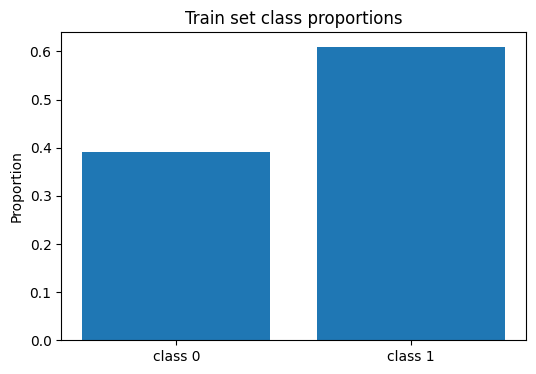

[Saved] ./cls_clusterid/test_class_balance.png


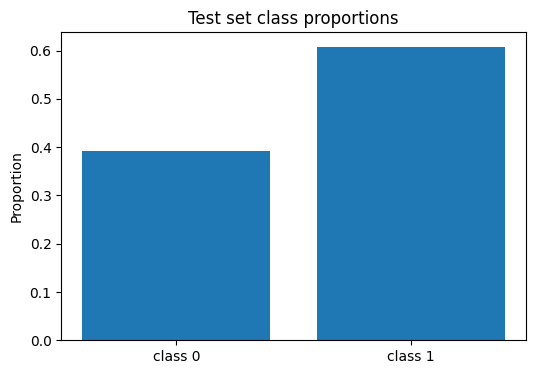


=== DONE ===
Outputs written to: ./cls_clusterid


In [ ]:
# ===========================================================
# Task: Classification #1 — Predict cluster_id (player persona)
# Fixes included for NaN/inf labels (IntCastingNaNError)
# - Data inputs:
#     1) player_summary.csv
#     2) ./cluster_figs/cluster_assignments.csv  (from your clustering step)
# - Features: fair set only (log_playtime_capped, achievement_count, ach_per_10h_nc, *_rank)
# - Models: LogisticRegression, RandomForest, HistGB, SVC (RBF)
# - CV: GridSearchCV + StratifiedKFold (refit by macro-F1)
# - Holdout: 20% stratified test
# - Outputs: ./cls_clusterid/
# ===========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    balanced_accuracy_score,
    top_k_accuracy_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

# ----------------------------
# Paths & config
# ----------------------------
CSV_PATH = "player_summary.csv"
ASSIGN_PATH = "./cluster_figs/cluster_assignments.csv"  # produced by clustering step
OUT_DIR = "./cls_clusterid"
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM_STATE = 42
TOTAL_ACH = 43

# ----------------------------
# Helpers
# ----------------------------
def percentile_rank(s: pd.Series) -> pd.Series:
    return s.rank(method="average", pct=True)

def savefig(dirpath: str, name: str):
    path = os.path.join(dirpath, name)
    plt.savefig(path, bbox_inches="tight", dpi=150)
    print(f"[Saved] {path}")

# ----------------------------
# Load raw + cluster labels
# ----------------------------
df = pd.read_csv(CSV_PATH)
df["steamid"] = df["steamid"].astype(str)

assign = pd.read_csv(ASSIGN_PATH)
assign["steamid"] = assign["steamid"].astype(str)

label_col = "cluster_kmeans" if "cluster_kmeans" in assign.columns else "cluster_gmm"
assign = assign[["steamid", label_col]].rename(columns={label_col: "cluster"})

# Clean cluster labels (fix NaN/inf/string)
assign["cluster"] = pd.to_numeric(assign["cluster"], errors="coerce")
missing_labels_in_assign = int(assign["cluster"].isna().sum())
if missing_labels_in_assign > 0:
    print(f"[Warn] {missing_labels_in_assign} rows in cluster_assignments.csv have NaN cluster. Dropping them from labels file.")
    assign = assign[assign["cluster"].notna()].copy()

# ----------------------------
# Fair features (consistent with earlier pipeline)
# ----------------------------
p99_play = df["playtime_forever"].quantile(0.99)
df["playtime_capped"] = np.clip(df["playtime_forever"], None, p99_play)
df["log_playtime_capped"] = np.log1p(df["playtime_capped"])

df["is_full_completion"] = (df["achievement_count"] >= TOTAL_ACH).astype(int)
mask_nc = df["is_full_completion"] == 0

# Efficiency for non-completers; 0 elsewhere
hours_nc = (df.loc[mask_nc, "playtime_capped"] / 60.0).replace(0, np.nan)
ach_nc = df.loc[mask_nc, "achievement_count"]
df["ach_per_10h_nc"] = 0.0
df.loc[mask_nc, "ach_per_10h_nc"] = (ach_nc / (hours_nc / 10.0)).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Category *_rank features (avoid raw percents & max_* leakage)
category_counts = [
    c for c in df.columns
    if c.endswith("_count")
    and c not in ["achievement_count"]
    and not c.startswith("max_")
]
rank_cols = []
for c in category_counts:
    rcol = c.replace("_count", "_rank")
    df[rcol] = percentile_rank(df[c].astype(float))
    rank_cols.append(rcol)

# ----------------------------
# Supervised dataset = non-completers ∩ labeled players
# ----------------------------
df_nc = df[df["is_full_completion"] == 0].copy()
data = df_nc.merge(assign, on="steamid", how="inner")  # keep rows with cluster labels

# Final cleaning of labels after merge
data["cluster"] = pd.to_numeric(data["cluster"], errors="coerce")
drop_na = int(data["cluster"].isna().sum())
if drop_na > 0:
    print(f"[Warn] {drop_na} merged rows have NaN cluster. Dropping them.")
    data = data[data["cluster"].notna()].copy()
data["cluster"] = data["cluster"].astype(int)

classes = sorted(data["cluster"].unique().tolist())
print(f"[Info] Classes present after cleaning: {classes} (n={len(classes)})")
if len(classes) < 2:
    raise ValueError("Need at least 2 classes for classification after cleaning. Check cluster_assignments.csv and non-completer subset.")

# ----------------------------
# Build features & target
# ----------------------------
feature_cols = ["log_playtime_capped", "achievement_count", "ach_per_10h_nc"] + rank_cols
feature_cols = [c for c in feature_cols if c in data.columns]

X = data[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
y = data["cluster"]

print(f"Training rows: {len(X)} | Features: {len(feature_cols)} | Classes: {sorted(y.unique())}")

# ----------------------------
# Train/valid/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# ----------------------------
# Define models & param grids (no subjective thresholds)
# ----------------------------
models = {
    "logreg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(multi_class="multinomial", class_weight="balanced",
                                   max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "rf": Pipeline([
        ("clf", RandomForestClassifier(class_weight="balanced_subsample", random_state=RANDOM_STATE))
    ]),
    "hgb": Pipeline([
        ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
    "svc": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=RANDOM_STATE))
    ]),
}

param_grids = {
    "logreg": {
        "clf__C": [0.1, 0.5, 1.0, 2.0, 5.0],
        "clf__penalty": ["l2"],
    },
    "rf": {
        "clf__n_estimators": [200, 400, 800],
        "clf__max_depth": [None, 8, 16, 24],
        "clf__min_samples_leaf": [1, 2, 5],
    },
    "hgb": {
        "clf__learning_rate": [0.05, 0.1, 0.2],
        "clf__max_depth": [None, 6, 10],
        "clf__max_leaf_nodes": [15, 31, 63],
    },
    "svc": {
        "clf__C": [0.5, 1.0, 2.0, 5.0],
        "clf__gamma": ["scale", 0.01, 0.05, 0.1],
    },
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"macro_f1": "f1_macro", "bal_acc": "balanced_accuracy"}

# ----------------------------
# GridSearchCV per model
# ----------------------------
cv_results_all = []
best_ests: Dict[str, Pipeline] = {}

for name, pipe in models.items():
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=cv,
        scoring=scoring,
        refit="macro_f1",
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)
    best_ests[name] = gs.best_estimator_
    res = pd.DataFrame(gs.cv_results_)
    res["model"] = name
    cv_results_all.append(res)
    print(f"\n=== {name} ===")
    print("Best params:", gs.best_params_)
    print("Best CV macro-F1:", gs.best_score_)

cv_results_all = pd.concat(cv_results_all, ignore_index=True)
cv_results_all.to_csv(os.path.join(OUT_DIR, "cv_results_all_models.csv"), index=False)
print(f"[Saved] {os.path.join(OUT_DIR, 'cv_results_all_models.csv')}")

# ----------------------------
# Holdout evaluation
# ----------------------------
test_rows = []
for name, est in best_ests.items():
    y_pred = est.predict(X_test)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    # top-2 accuracy if proba available
    try:
        proba = est.predict_proba(X_test)
        top2 = top_k_accuracy_score(y_test, proba, k=2, labels=np.unique(y_test))
    except Exception:
        top2 = np.nan

    # save per-class report + confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    pd.DataFrame(report).T.to_csv(os.path.join(OUT_DIR, f"test_report_{name}.csv"))
    cm = confusion_matrix(y_test, y_pred)
    pd.DataFrame(cm).to_csv(os.path.join(OUT_DIR, f"confusion_matrix_{name}.csv"), index=False)

    test_rows.append({
        "model": name,
        "macro_f1": macro_f1,
        "balanced_accuracy": bal_acc,
        "top2_accuracy": top2
    })

test_summary = pd.DataFrame(test_rows).sort_values("macro_f1", ascending=False)
test_summary.to_csv(os.path.join(OUT_DIR, "test_summary.csv"), index=False)
print(f"[Saved] {os.path.join(OUT_DIR, 'test_summary.csv')}")
print(test_summary)

# ----------------------------
# Feature importance / coefficients / permutation importance
# ----------------------------
def export_importance(est: Pipeline, name: str):
    out = os.path.join(OUT_DIR, f"feature_importance_{name}.csv")
    # tree-based importance
    if hasattr(est[-1], "feature_importances_"):
        imp = est[-1].feature_importances_
        pd.DataFrame({"feature": feature_cols, "importance": imp}).sort_values(
            "importance", ascending=False).to_csv(out, index=False)
        print(f"[Saved] {out}")
        return True
    # linear abs(coef)
    if hasattr(est[-1], "coef_"):
        coefs = np.mean(np.abs(est[-1].coef_), axis=0)
        pd.DataFrame({"feature": feature_cols, "abs_coef": coefs}).sort_values(
            "abs_coef", ascending=False).to_csv(out, index=False)
        print(f"[Saved] {out}")
        return True
    return False

for name, est in best_ests.items():
    ok = export_importance(est, name)
    if not ok:
        # permutation importance on test set (model-agnostic)
        try:
            result = permutation_importance(est, X_test, y_test, n_repeats=5,
                                            random_state=RANDOM_STATE, n_jobs=-1)
            imp_df = pd.DataFrame({"feature": feature_cols,
                                   "perm_importance_mean": result.importances_mean})
            imp_df.sort_values("perm_importance_mean", ascending=False).to_csv(
                os.path.join(OUT_DIR, f"feature_importance_perm_{name}.csv"), index=False
            )
            print(f"[Saved] {os.path.join(OUT_DIR, f'feature_importance_perm_{name}.csv')}")
        except Exception as e:
            print(f"[Skip permutation importance for {name}]: {e}")

# ----------------------------
# Sanity plots: class balance
# ----------------------------
plt.figure(figsize=(6,4))
vals = pd.Series(y_train).value_counts(normalize=True).sort_index()
plt.bar(range(len(vals)), vals.values)
plt.xticks(range(len(vals)), [f"class {c}" for c in vals.index])
plt.ylabel("Proportion")
plt.title("Train set class proportions")
savefig(OUT_DIR, "train_class_balance.png"); plt.show()

plt.figure(figsize=(6,4))
vals = pd.Series(y_test).value_counts(normalize=True).sort_index()
plt.bar(range(len(vals)), vals.values)
plt.xticks(range(len(vals)), [f"class {c}" for c in vals.index])
plt.ylabel("Proportion")
plt.title("Test set class proportions")
savefig(OUT_DIR, "test_class_balance.png"); plt.show()

print("\n=== DONE ===")
print(f"Outputs written to: {OUT_DIR}")


,model,macro_f1,balanced_accuracy,top2_accuracy
0,svc,0.511772,0.515819,NaN
1,logreg,0.478767,0.479081,NaN
2,hgb,0.475459,0.485810,NaN
3,rf,0.464229,0.466001,NaN


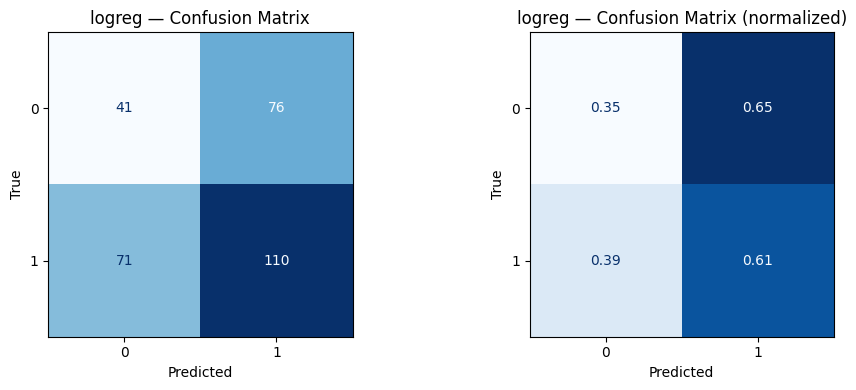

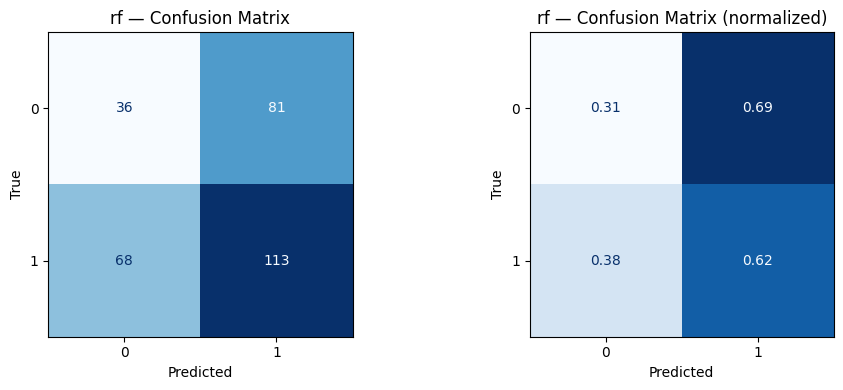

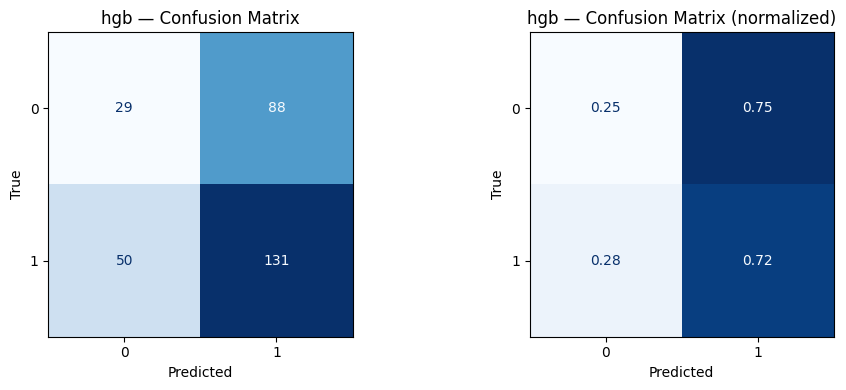

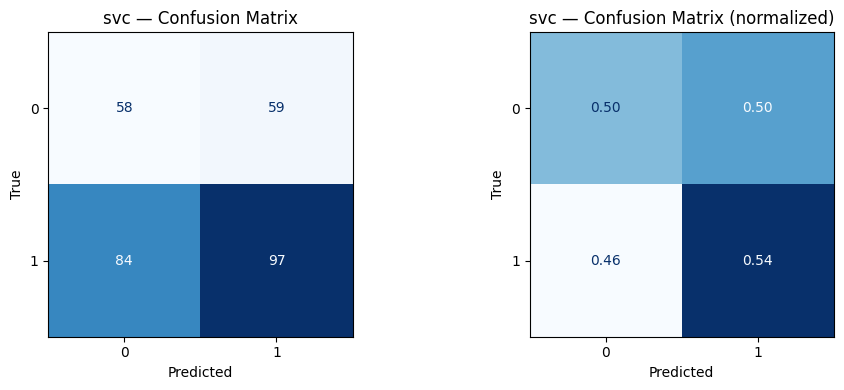

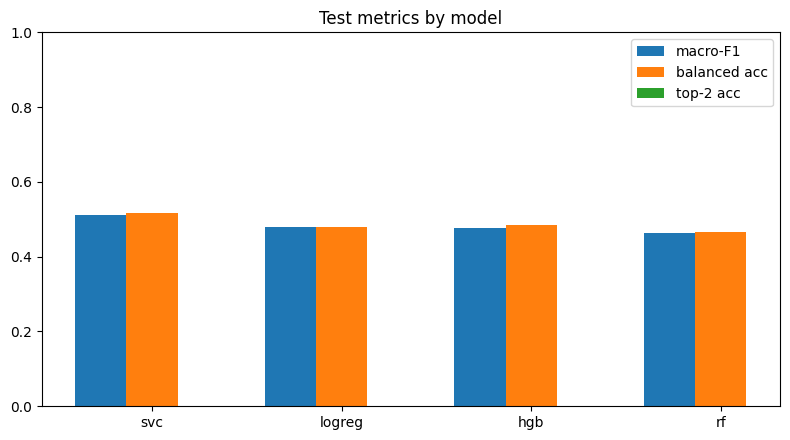

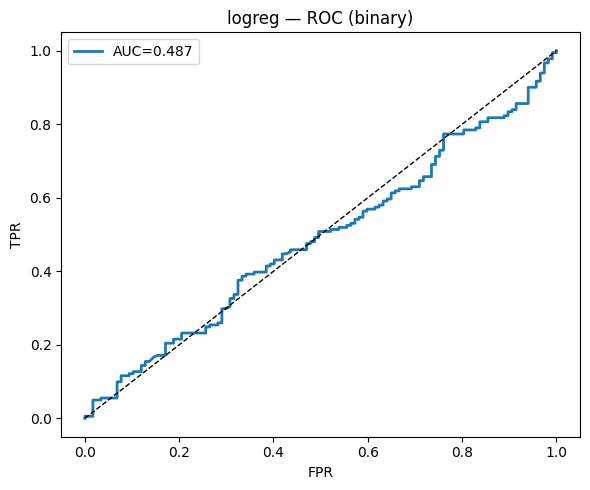

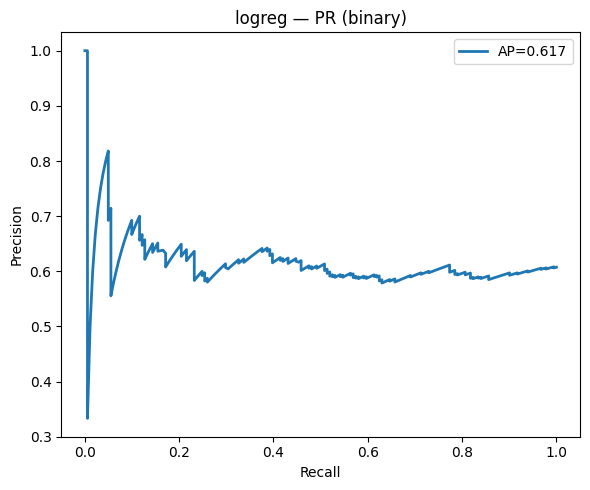

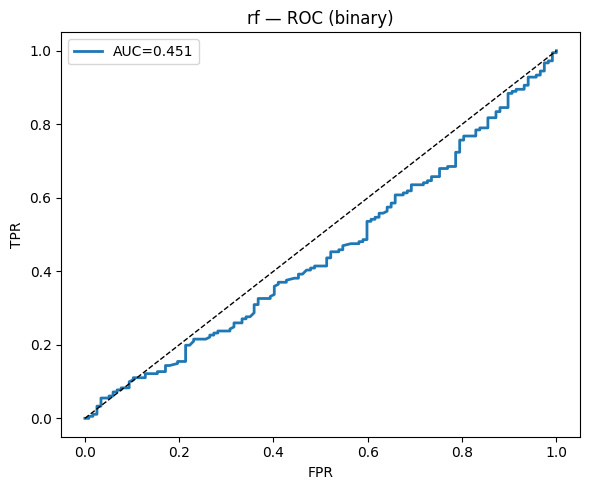

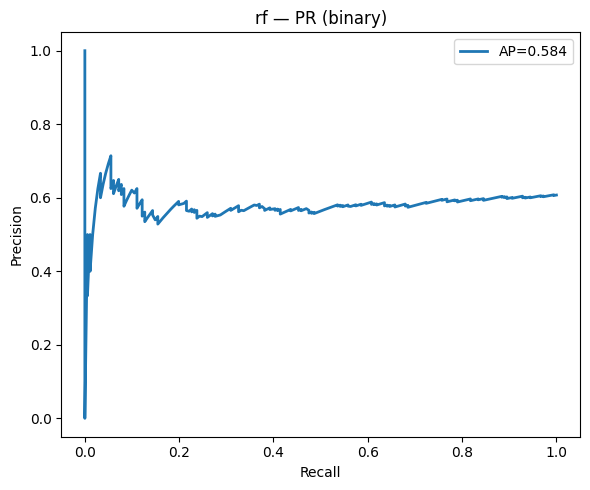

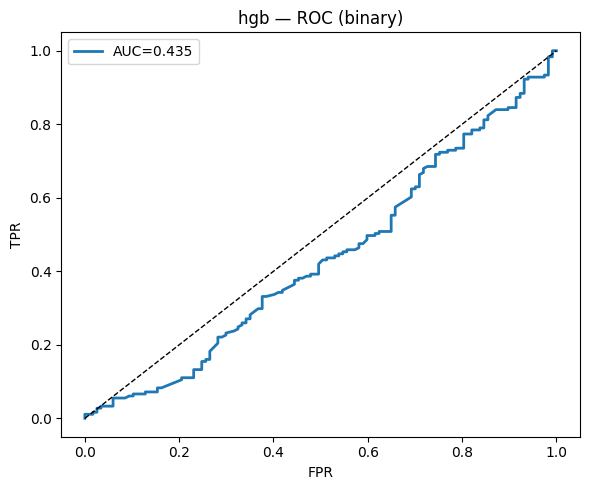

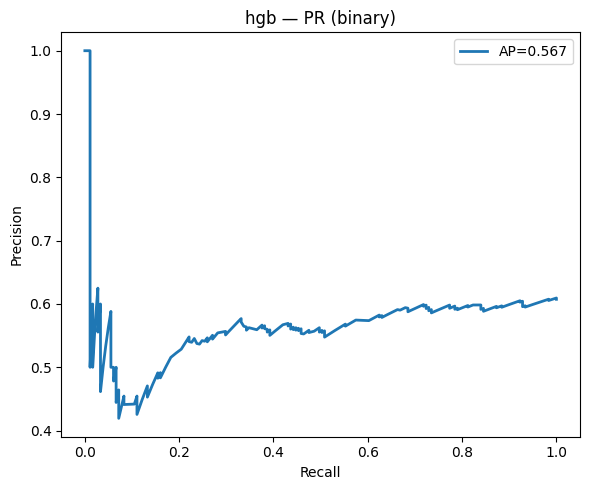

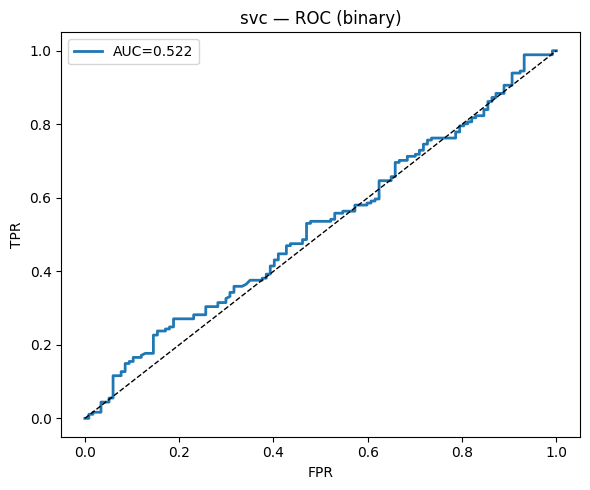

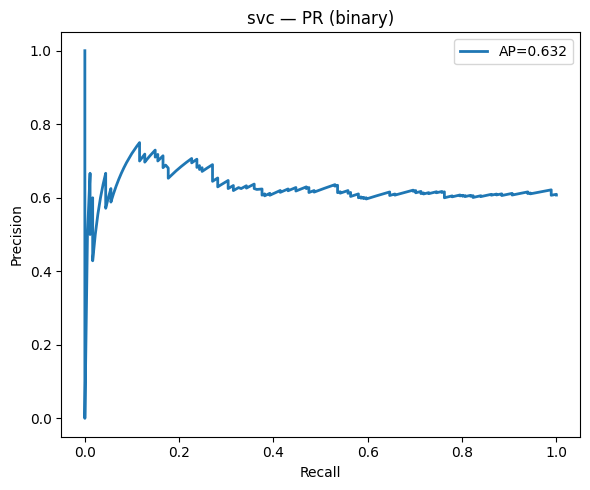

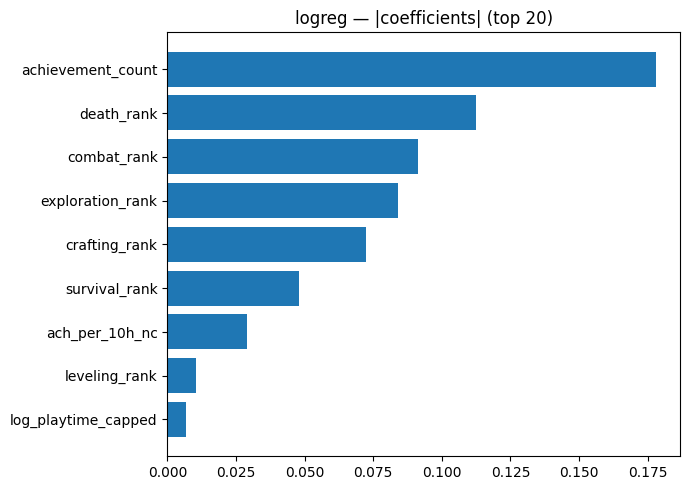

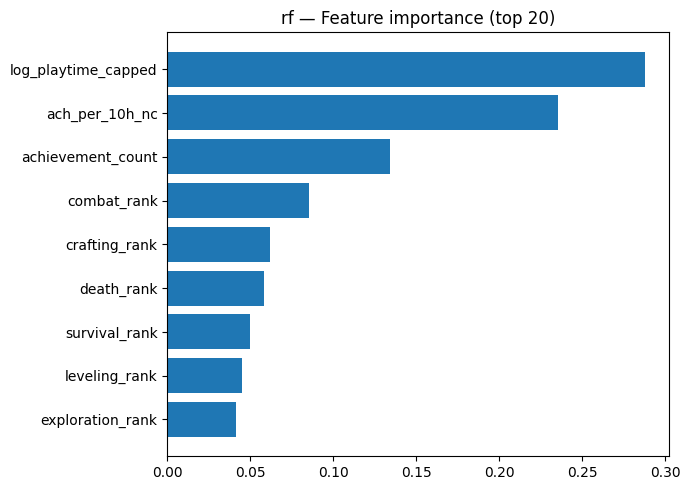

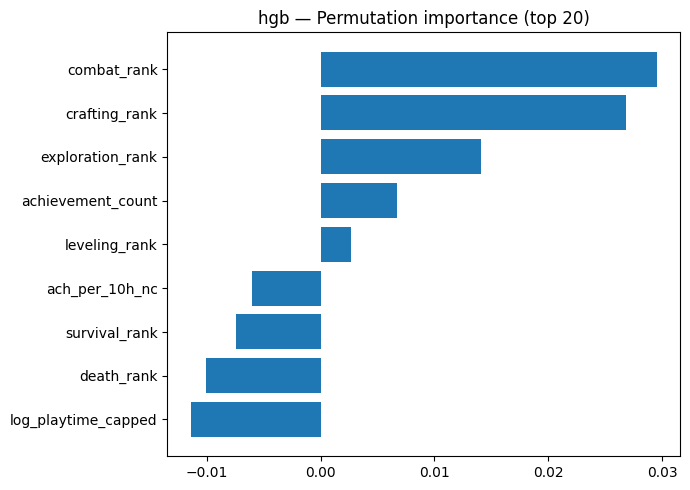

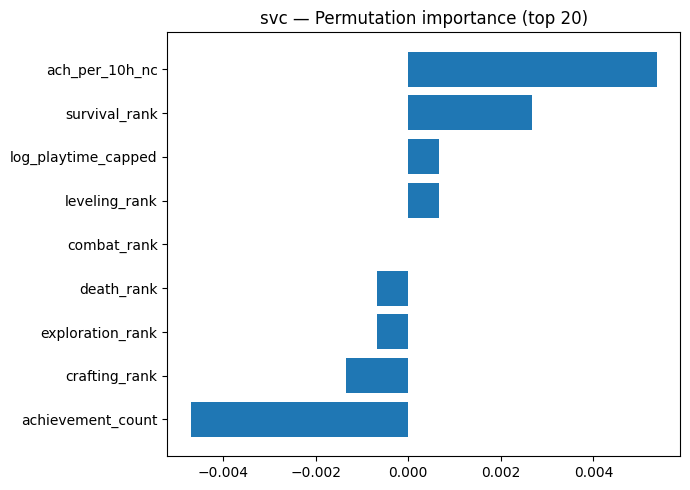

In [7]:
# ============================
# INLINE VIS: cluster classification results (no saving)
# Requires: best_ests, X_test, y_test, feature_cols
# Optional: OUT_DIR (only to read test_summary.csv if you already saved it; else we'll compute on the fly)
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, balanced_accuracy_score, top_k_accuracy_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    classification_report
)
from sklearn.preprocessing import label_binarize
from sklearn.inspection import permutation_importance

# --- Sanity: build a test_summary on the fly if not available ---
try:
    test_summary = pd.read_csv(f"{OUT_DIR}/test_summary.csv")
except Exception:
    rows = []
    for name, est in best_ests.items():
        y_pred = est.predict(X_test)
        macro_f1 = f1_score(y_test, y_pred, average="macro")
        bal_acc  = balanced_accuracy_score(y_test, y_pred)
        try:
            proba = est.predict_proba(X_test)
            top2 = top_k_accuracy_score(y_test, proba, k=2, labels=np.unique(y_test))
        except Exception:
            top2 = np.nan
        rows.append({"model": name, "macro_f1": macro_f1, "balanced_accuracy": bal_acc, "top2_accuracy": top2})
    test_summary = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)

display(test_summary)

classes = np.sort(np.unique(y_test))
n_classes = len(classes)

# 1) Confusion matrices (raw + normalized)
for name, est in best_ests.items():
    y_pred = est.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_norm = confusion_matrix(y_test, y_pred, labels=classes, normalize="true")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format="d", cmap="Blues", colorbar=False, ax=ax[0])
    ax[0].set_title(f"{name} — Confusion Matrix")
    ConfusionMatrixDisplay(cm_norm, display_labels=classes).plot(values_format=".2f", cmap="Blues", colorbar=False, ax=ax[1])
    ax[1].set_title(f"{name} — Confusion Matrix (normalized)")
    for a in ax: 
        a.set_xlabel("Predicted"); a.set_ylabel("True")
    plt.tight_layout()
    plt.show()

# 2) Metric bar chart (macro‑F1, balanced acc, top‑2)
plt.figure(figsize=(8, 4.5))
x = np.arange(len(test_summary))
w = 0.27
plt.bar(x - w, test_summary["macro_f1"], width=w, label="macro‑F1")
plt.bar(x,       test_summary["balanced_accuracy"], width=w, label="balanced acc")
plt.bar(x + w,   test_summary["top2_accuracy"], width=w, label="top‑2 acc")
plt.xticks(x, test_summary["model"])
plt.ylim(0, 1.0)
plt.title("Test metrics by model")
plt.legend()
plt.tight_layout()
plt.show()

# 3) ROC & PR curves (probability or decision_function)
def get_scores(est, X):
    # prefer predict_proba
    if hasattr(est, "predict_proba"):
        try:
            proba = est.predict_proba(X)
            if proba.ndim == 2 and proba.shape[1] == 1:
                return proba.ravel(), True  # binary as 1D
            return proba, True
        except Exception:
            pass
    # fallback: decision_function
    if hasattr(est, "decision_function"):
        dec = est.decision_function(X)
        if dec.ndim == 1:
            return dec, False
        return dec, False
    return None, False

for name, est in best_ests.items():
    scores, _ = get_scores(est, X_test)
    if scores is None:
        continue

    if n_classes == 2:
        # Binary curves
        pos_scores = scores[:, 1] if (scores.ndim == 2 and scores.shape[1] >= 2) else scores
        y_true_bin = (y_test == classes[1]).astype(int)

        fpr, tpr, _ = roc_curve(y_true_bin, pos_scores)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.3f}")
        plt.plot([0,1], [0,1], "k--", lw=1)
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{name} — ROC (binary)")
        plt.legend(); plt.tight_layout(); plt.show()

        prec, rec, _ = precision_recall_curve(y_true_bin, pos_scores)
        ap = average_precision_score(y_true_bin, pos_scores)
        plt.figure(figsize=(6,5))
        plt.plot(rec, prec, lw=2, label=f"AP={ap:.3f}")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{name} — PR (binary)")
        plt.legend(); plt.tight_layout(); plt.show()
    else:
        # Multiclass OvR + micro
        if scores.ndim == 1:
            continue
        y_bin = label_binarize(y_test, classes=classes)

        plt.figure(figsize=(6,5))
        for i, c in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1.5, label=f"class {c} (AUC={roc_auc:.3f})")
        fpr_m, tpr_m, _ = roc_curve(y_bin.ravel(), scores.ravel())
        auc_m = auc(fpr_m, tpr_m)
        plt.plot(fpr_m, tpr_m, "k--", lw=2, label=f"micro (AUC={auc_m:.3f})")
        plt.plot([0,1], [0,1], "k--", lw=1)
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{name} — ROC (OvR)")
        plt.legend(fontsize=8); plt.tight_layout(); plt.show()

        plt.figure(figsize=(6,5))
        ap_micro = average_precision_score(y_bin, scores, average="micro")
        for i, c in enumerate(classes):
            prec, rec, _ = precision_recall_curve(y_bin[:, i], scores[:, i])
            ap = average_precision_score(y_bin[:, i], scores[:, i])
            plt.plot(rec, prec, lw=1.5, label=f"class {c} (AP={ap:.3f})")
        plt.title(f"{name} — PR (micro AP={ap_micro:.3f})")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.legend(fontsize=8); plt.tight_layout(); plt.show()

# 4) Feature importance / coefficients / permutation importance (inline)
def plot_topk_bar(names, vals, title):
    order = np.argsort(vals)[::-1][:20]
    plt.figure(figsize=(7,5))
    plt.barh(np.array(names)[order][::-1], np.array(vals)[order][::-1])
    plt.title(title); plt.tight_layout(); plt.show()

for name, est in best_ests.items():
    if hasattr(est[-1], "feature_importances_"):
        vals = est[-1].feature_importances_
        plot_topk_bar(feature_cols, vals, f"{name} — Feature importance (top 20)")
    elif hasattr(est[-1], "coef_"):
        vals = np.mean(np.abs(est[-1].coef_), axis=0)
        plot_topk_bar(feature_cols, vals, f"{name} — |coefficients| (top 20)")
    else:
        # permutation importance (test set)
        try:
            result = permutation_importance(est, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
            plot_topk_bar(feature_cols, result.importances_mean, f"{name} — Permutation importance (top 20)")
        except Exception as e:
            print(f"[Skip permutation importance for {name}]: {e}")


Silhouette of GIVEN labels on current features: 0.013
ARI between GIVEN labels and KMeans on SAME features: 0.007


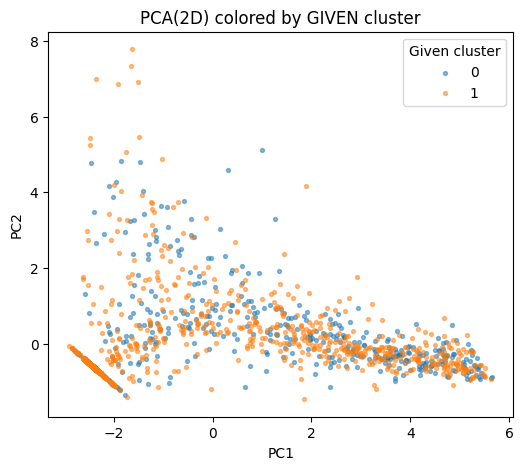

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# 用你前面训练集/特征
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# (a) 直接用你给的 cluster 标签算个轮廓系数（越接近1越好，~0=不可分）
sil_given = silhouette_score(X_std, y, metric="euclidean")
print("Silhouette of GIVEN labels on current features:", round(sil_given, 3))

# (b) 在同一特征上重跑一次 KMeans(k=2)，看看和给定标签的一致性（ARI）
km = KMeans(n_clusters=2, n_init=25, random_state=42).fit(X_std)
ari = adjusted_rand_score(y, km.labels_)
print("ARI between GIVEN labels and KMeans on SAME features:", round(ari, 3))

# (c) 可视化：PCA二维 + 你给的标签上色
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_std)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
for c in sorted(y.unique()):
    m = (y.values == c)
    plt.scatter(X_pca[m,0], X_pca[m,1], s=8, alpha=0.5, label=str(c))
plt.legend(title="Given cluster")
plt.title("PCA(2D) colored by GIVEN cluster")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()
